In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

Generate 100 data points of dimension 6:

In [517]:
n = 100

t = np.linspace(0,n,n)

x1 = np.reshape(10*np.cos(0.12*t), (n,1))
x2 = np.reshape(6*np.sin(0.12*t), (n,1))
x3 = np.reshape(t, (n,1))
x4 = np.reshape(8*np.sin(0.03*t), (n,1))
x5 = np.reshape(4*np.sin(0.05*t), (n,1))
x6 = np.reshape(2*np.cos(0.03*t), (n,1))


X1 = np.concatenate((x1,x2,x3), axis=1)
X2 = np.concatenate((x4,x5,x6), axis=1)
#Last three dimensions is S curve
#X2, t2 = datasets.make_s_curve(n_samples=n, noise=0.0, random_state=None)

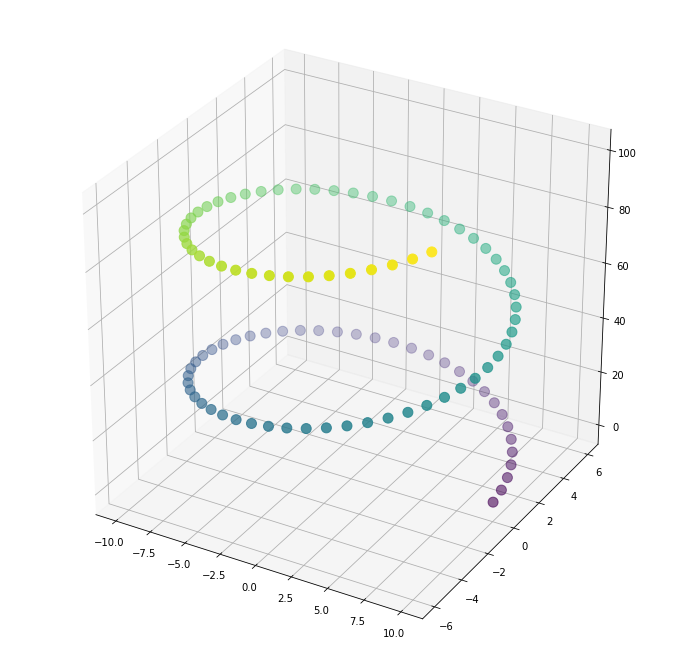

In [518]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(X1[:,0], X1[:,1], X1[:,2], c=t, s=100)

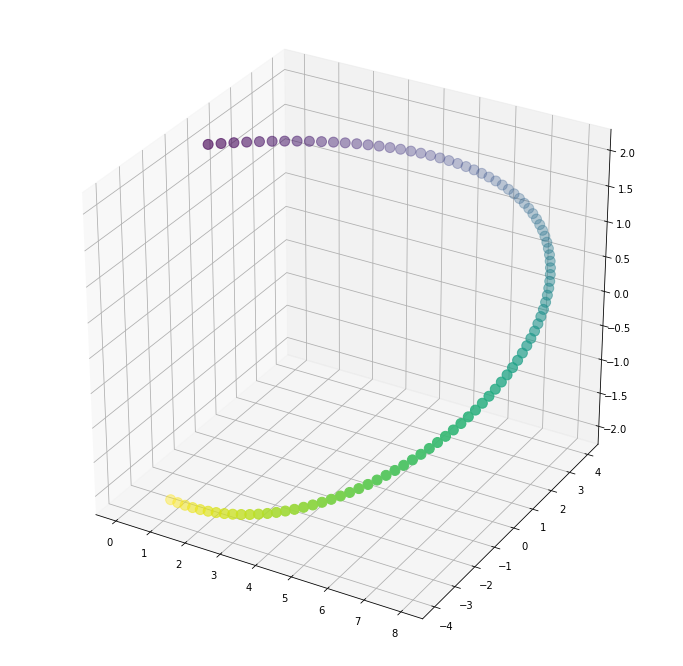

In [519]:
fig = plt.figure(figsize=(12, 12))

ax2 = fig.add_subplot(projection='3d')

ax2.scatter(X2[:,0], X2[:,1], X2[:,2], c=t, s=100)

In [520]:
X = np.concatenate((X1, X2), axis=1)
X.shape

(100, 6)

In [521]:
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances

In [522]:
MDS_embed = MDS(n_components=2)
X_mds = MDS_embed.fit_transform(X)

In [523]:
X_mds.shape

(100, 2)

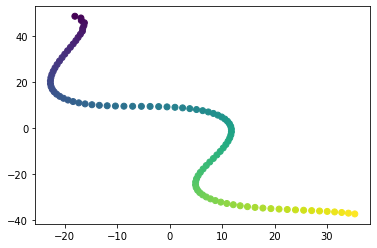

In [524]:
plt.scatter(X_mds[:,0], X_mds[:,1], c=t)

Create k neighbors graph:

In [540]:
A = np.array(NearestNeighbors(n_neighbors=5).fit(X).kneighbors_graph(X).todense())

In [541]:


D = cp.Constant(pairwise_distances(X))

B = cp.Variable((n,n), PSD=True)
objective = cp.Maximize(cp.trace(B))

constraints = [cp.sum(cp.sum(B,axis=1), axis=0)==0]
for i in range(n):
  for j in range(n):
    if A[i,j] == 1:
      constraints.append((B[i,i]+B[j,j]-2*B[i,j])-D[i,j]**2 == 0)




problem = cp.Problem(objective, constraints)

problem.solve(solver=cp.SCS,
                      eps=1e-2,
                      max_iters=2500,
                      warm_start=False)

112478.29360249356

In [542]:
Lambda, U = np.linalg.eig(B.value)

Due to numerical errors, we still get some (small) negative eigenvalues. Eliminate them.

In [543]:
#Zero out negative eigenvalues.
Lambda[Lambda < 0] = 0.

largest_eigenvalues_indices = Lambda.argsort()[::-1][:2]

largest_eigenvalues = Lambda[largest_eigenvalues_indices]
largest_eigenvectors = U[:, largest_eigenvalues_indices]

sqrt_lambda = np.diag(np.sqrt(largest_eigenvalues))

X_embedded = np.matmul(sqrt_lambda, largest_eigenvectors.T).T

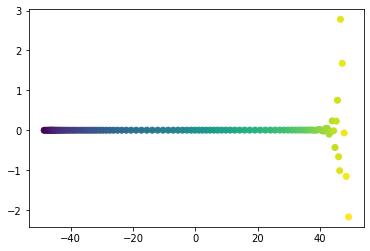

In [544]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=t)